In [1]:
from pandas import read_csv
from pandas import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error

C:\Users\Simo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.kaggle.com/poiupoiu/how-to-use-sarimax

## Reading and preprocessing the data


### NASA GISTEMP Global Means

In [2]:
glb = read_csv('weather_data/GLB.Ts.csv', skiprows=1)
glb.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.76,-0.35,-0.42,-0.60,-0.30,-0.42,-0.41,0.13,-0.44,-0.60,-0.45,-0.47,-0.43,***,***,-0.44,-0.24,-0.50
1,1881,-0.74,-0.56,-0.31,-0.21,0.02,-1.05,-0.47,-0.19,-0.29,-0.42,-0.50,-0.09,-0.40,-.43,-.59,-0.16,-0.57,-0.40
2,1882,0.18,-0.05,-0.03,-0.54,-0.33,-0.97,-0.66,-0.06,-0.02,-0.25,-0.34,-0.62,-0.31,-.26,.01,-0.30,-0.56,-0.20
3,1883,-0.62,-0.89,-0.40,-0.26,-0.30,0.50,0.04,-0.10,-0.40,-0.51,-0.63,-0.33,-0.32,-.35,-.71,-0.32,0.15,-0.51
4,1884,-0.56,-0.30,-0.36,-0.90,-1.16,-0.79,-0.81,0.19,-0.33,-0.73,-0.78,-0.97,-0.63,-.57,-.40,-0.81,-0.47,-0.61


In [3]:
#https://data.giss.nasa.gov/gistemp/
def preprocess_temp_anomaly(anomaly):
    
    col_names =  ['DateTime', 'anomaly']
    glb_formatted = pd.DataFrame(columns = col_names)
    
    at = 0
    for index, row in glb.iterrows():
        i = 0
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for r in row[1:13]:
            date = pd.to_datetime(str(row['Year']) + '-' + months[i])
            value = r
            glb_formatted.loc[at] = [date, value]
            at = at + 1
            i = i + 1
        i= 1
    
    glb_formatted = glb_formatted.set_index(['DateTime'])
    
    return glb_formatted


glb_formatted = preprocess_temp_anomaly(glb)
glb_formatted.head()

,anomaly
DateTime,
1880-01-01,-0.76
1880-02-01,-0.35
1880-03-01,-0.42
1880-04-01,-0.60
1880-05-01,-0.30


### Monthly mean carbon dioxide at Mauna Loa Observatory, Hawaii

In [4]:
columns= ['Year', 'Month', 'Excel', 'Date', 'CO2', 'sesonalCO2', 'FIT','sesonalFIT', 'CO2filled', 'seasonalCO2filled']

maunaloa = read_csv('weather_data/maunaloa.csv', skiprows=57, header=None, names=columns)

maunaloa['DateTime']  = pd.to_datetime(maunaloa.Year.map(str) + '-' + maunaloa.Month.map(str))
maunaloa = maunaloa.set_index(['DateTime'])

maunaloa.head()

,Year,Month,Excel,Date,CO2,sesonalCO2,FIT,sesonalFIT,CO2filled,seasonalCO2filled
DateTime,,,,,,,,,,
1958-01-01,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-02-01,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-03-01,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1958-04-01,1958,4,21290,1958.2877,317.45,315.15,317.30,314.98,317.45,315.15
1958-05-01,1958,5,21320,1958.3699,317.51,314.72,317.85,315.06,317.51,314.72


In [5]:
maunaloaFilled = maunaloa[['CO2filled', 'seasonalCO2filled']].copy()
maunaloaFilled.replace(to_replace=[-99.99], value=np.nan, inplace=True)

### The Oceanic Niño Index (ONI) 

In [6]:
#https://data.humdata.org/dataset/monthly-oceanic-nino-index-oni
#https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt

In [7]:
enso = read_csv('weather_data/ONIindex.csv',delim_whitespace=True)

In [8]:
enso['DateTime'] = pd.to_datetime(enso.YR.map(str) + '-' + enso.MON.map(str))
enso = enso.set_index(['DateTime']) 

In [9]:
enso.tail()

,YR,MON,TOTAL,ClimAdjust,ANOM
DateTime,,,,,
2018-09-01,2018,9,27.19,26.80,0.39
2018-10-01,2018,10,27.62,26.75,0.86
2018-11-01,2018,11,27.61,26.75,0.86
2018-12-01,2018,12,27.49,26.65,0.84
2019-01-01,2019,1,27.25,26.45,0.80


### Sunspot Number

In [10]:
#http://www.sidc.be/silso/monthlyssnplot
#http://www.sidc.be/silso/newdataset
columns= ['Year', 'Month', 'decimalYear', 'SNvalue' , 'SNerror', 'NBobservations', 'unspesified']
sunspots = read_csv('weather_data/SN_m_tot_V2.0.csv', sep=';', header=None, names=columns)

In [11]:
sunspots['DateTime'] = pd.to_datetime(sunspots.Year.map(str) + '-' + sunspots.Month.map(str))

In [12]:
sunspots = sunspots.set_index(['DateTime'])  

In [13]:
sunspots.head()

,Year,Month,decimalYear,SNvalue,SNerror,NBobservations,unspesified
DateTime,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


### Range there is data of all the variables

In [14]:
#Choosing a range there is data of
anomalyrange = glb_formatted['1960-01-01' : '2018-12-01']
co2range = maunaloaFilled[['CO2filled']]['1960-01-01' : '2018-12-01']  #.CO2filled['1960-01-01' : '2018-12-01']
ensorange = enso[['ANOM']]['1960-01-01' : '2018-12-01']
spotsrange = sunspots[['SNvalue']]['1960-01-01' : '2018-12-01']

In [15]:
exogenous = pd.concat([co2range,ensorange,spotsrange], axis=1)

In [16]:
exogenous.tail()

,CO2filled,ANOM,SNvalue
DateTime,,,
2018-08-01,407.10,0.04,8.7
2018-09-01,405.59,0.39,3.3
2018-10-01,405.99,0.86,4.9
2018-11-01,408.12,0.86,5.9
2018-12-01,409.23,0.84,3.1


## Plotting the data

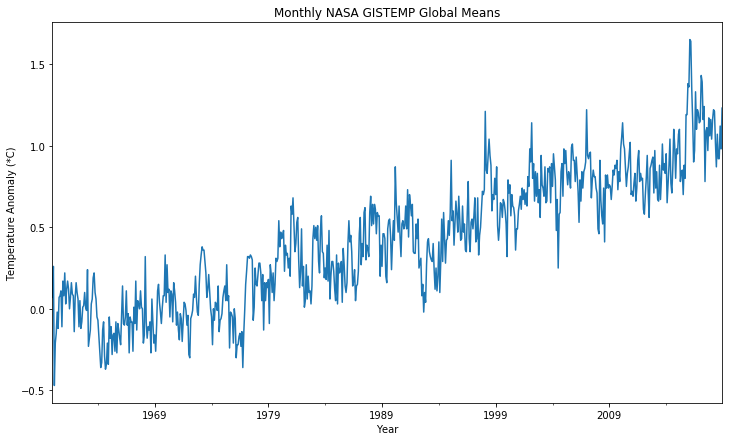

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
anomalyrange.anomaly.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (*C)')
plt.title('Monthly NASA GISTEMP Global Means')
plt.show()


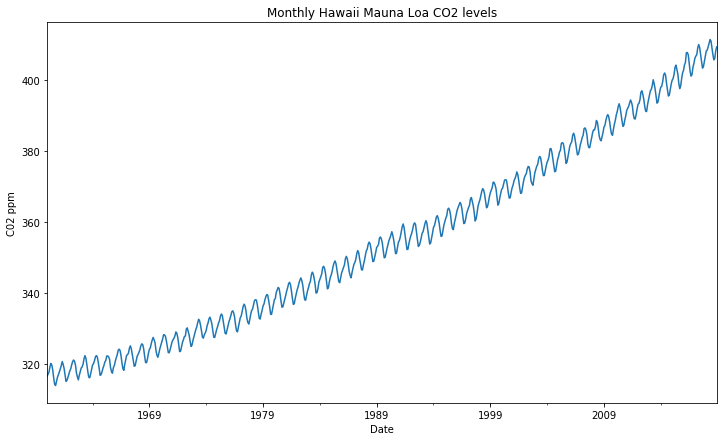

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
co2range.CO2filled.plot(ax=ax)

plt.xlabel('Date')
plt.ylabel('C02 ppm')
plt.title('Monthly Hawaii Mauna Loa CO2 levels')
plt.show()

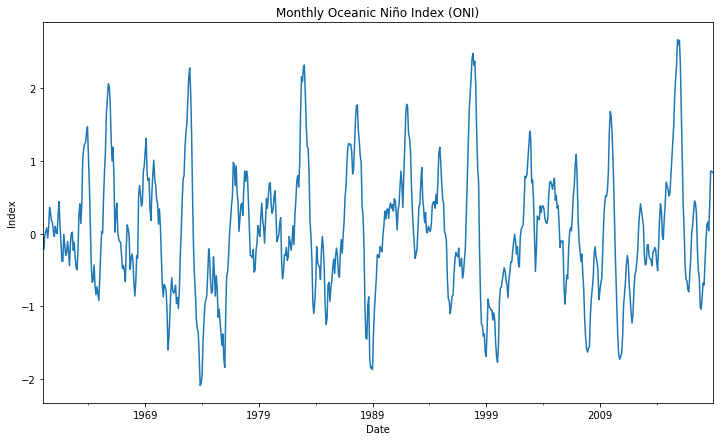

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ensorange.ANOM.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Monthly Oceanic Niño Index (ONI)')
plt.show()

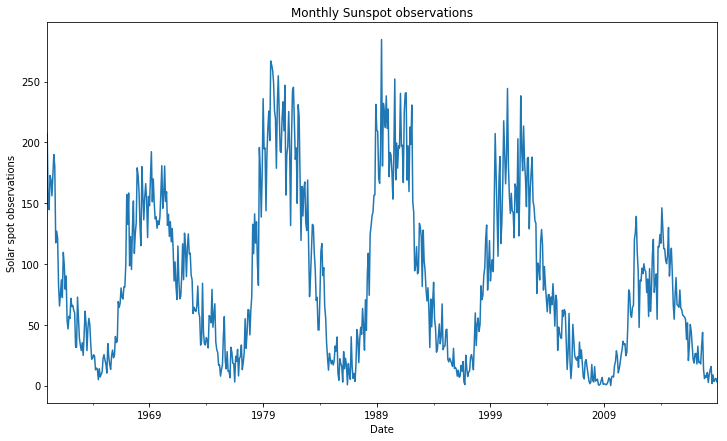

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
spotsrange.SNvalue.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Solar spot observations')
plt.title('Monthly Sunspot observations')
plt.show()

## Seasonal Decompositions

### Temperature anomaly

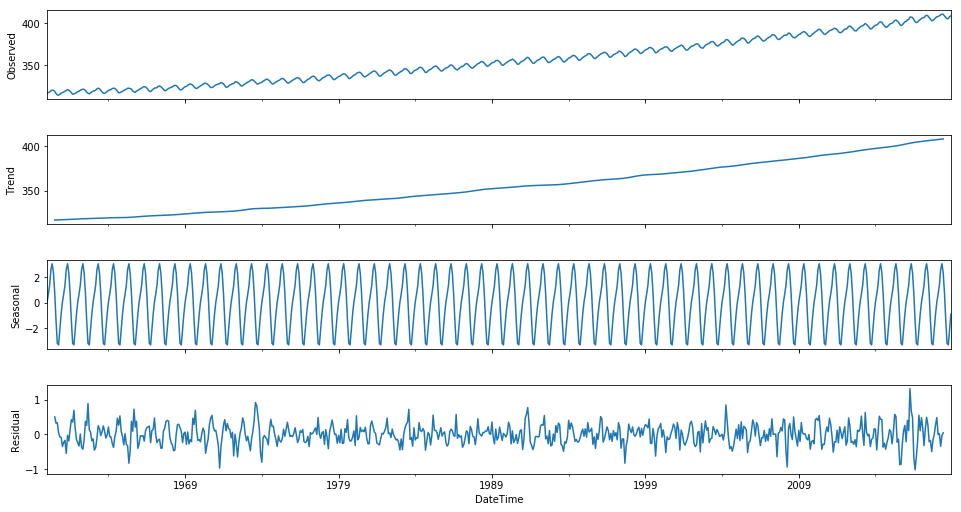

In [21]:
res = sm.tsa.seasonal_decompose(co2range.CO2filled,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Hawaii CO2 ppm 

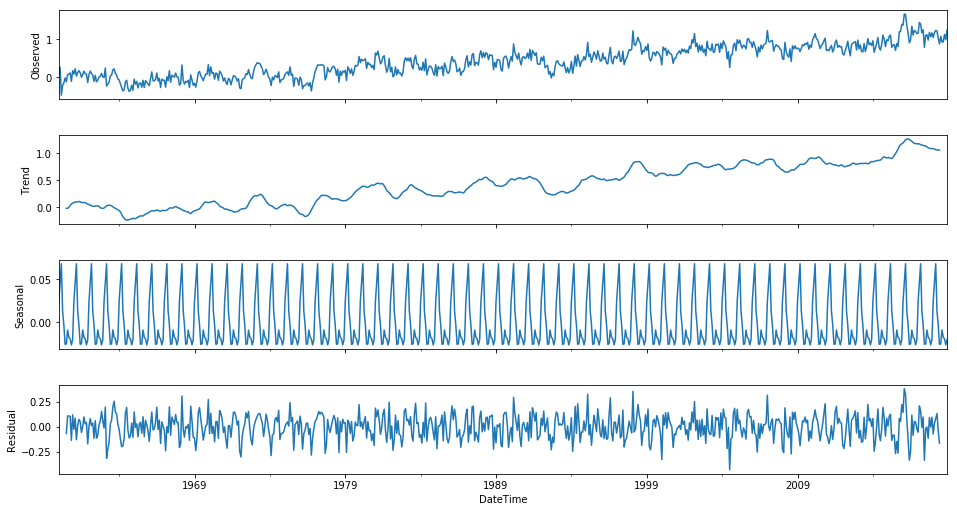

In [22]:
res = sm.tsa.seasonal_decompose(anomalyrange.anomaly,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### The Oceanic Niño Index (ONI)

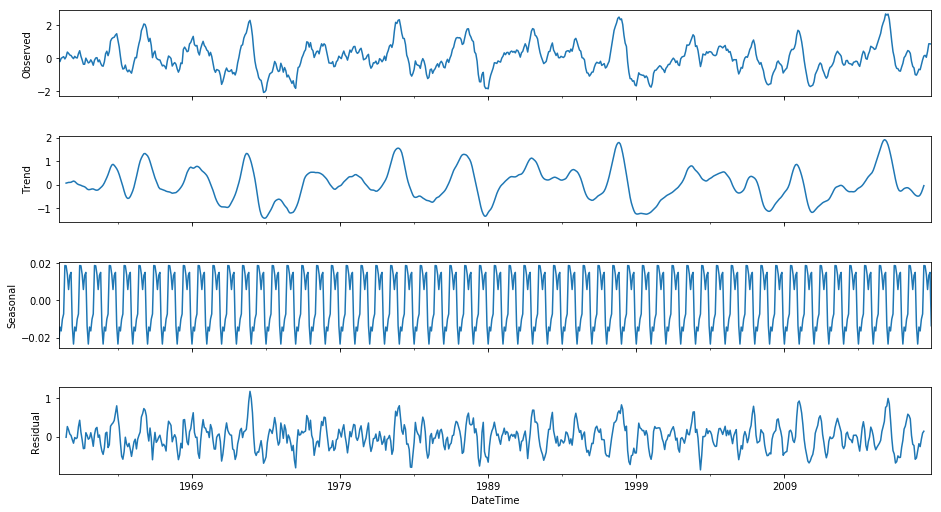

In [27]:
res = sm.tsa.seasonal_decompose(ensorange.ANOM,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Sunspot observations

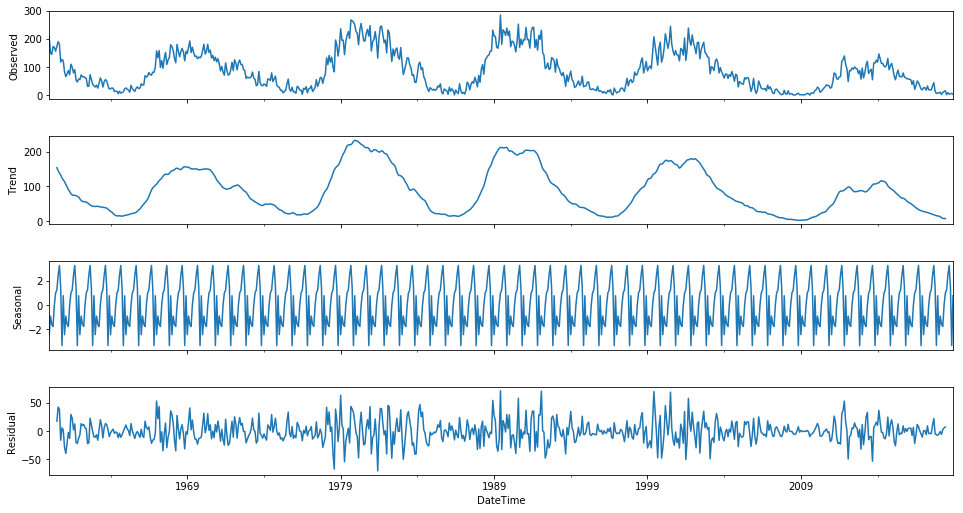

In [28]:
res = sm.tsa.seasonal_decompose(spotsrange.SNvalue,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Model Selection

In [13]:
#ARIMA model:(p,d,q)
#SARIMA model:(p,d,q)(P,D,Q,m)
#ARIMAX model:(p,d,q) + exog
#SARIMAX model:(p,d,q)(P,D,Q,m) +exog

#ARIMA(p,d,q)
#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

### Checking Stationarity (Trend)

#### Temperature anomaly

Temperature anomaly lacks identifiable seasonal trend, but has a constant trend

In [14]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='ct')
print('p-value:{}'.format(res[1]))
# data does not have a unit root and is stationary

p-value:1.6042922157092146e-09


In [15]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.5914744988244862


#### Hawaii CO2 ppm 

CO2 concentration has both a seasonal and a constant trend

In [16]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.9885944880242227


In [38]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:1.0


#### The Oceanic Niño Index (ONI) and Sunspot observations

ONI and Sunspot observations have no trend

In [36]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:4.519555052443993e-08


In [40]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:2.5062854384841634e-09


In [39]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0030167208232305537


In [41]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0007375824522553518


### Correlograms

In [18]:
#diff is for unit root processes
#x.diff().dropna() dropna because the first element is nan. 

#### Temperature anomaly

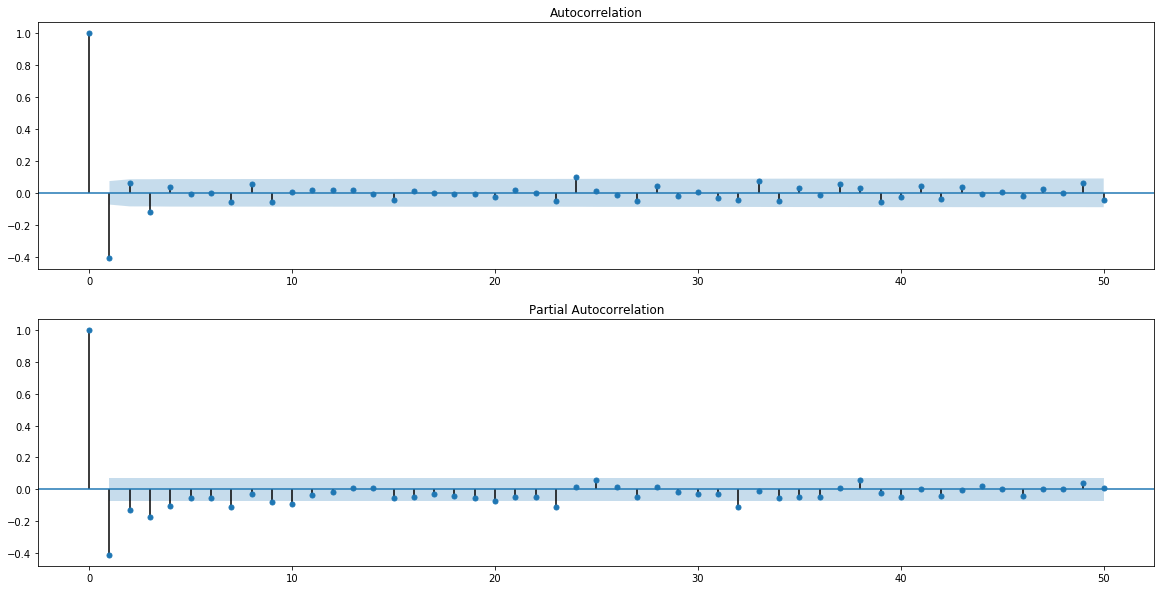

In [19]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### Hawaii CO2 ppm

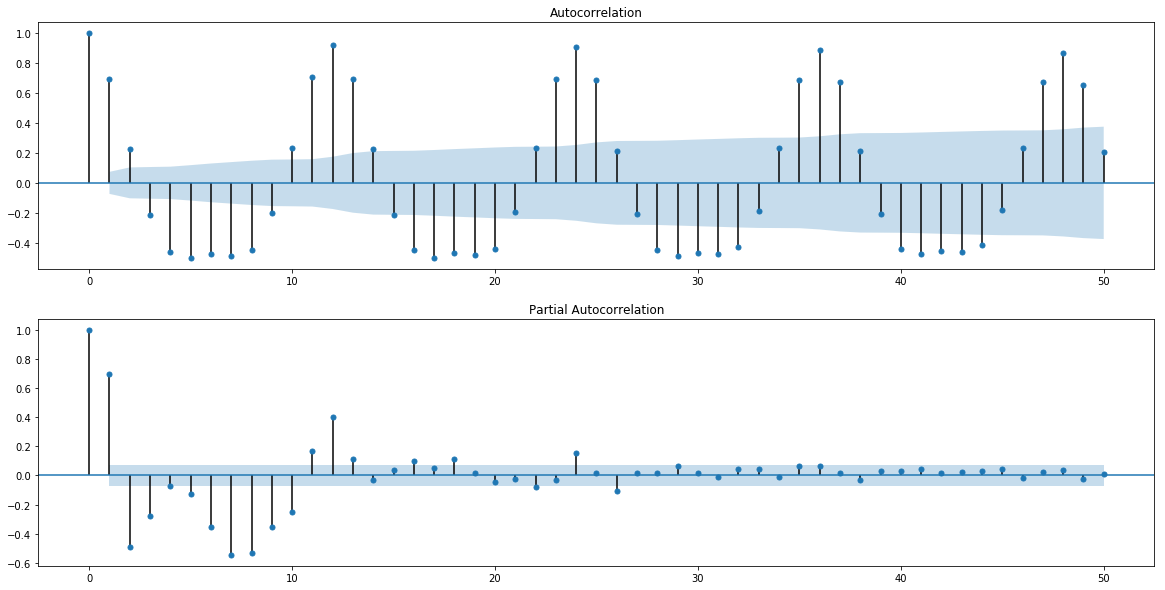

In [20]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### The Oceanic Niño Index (ONI) 

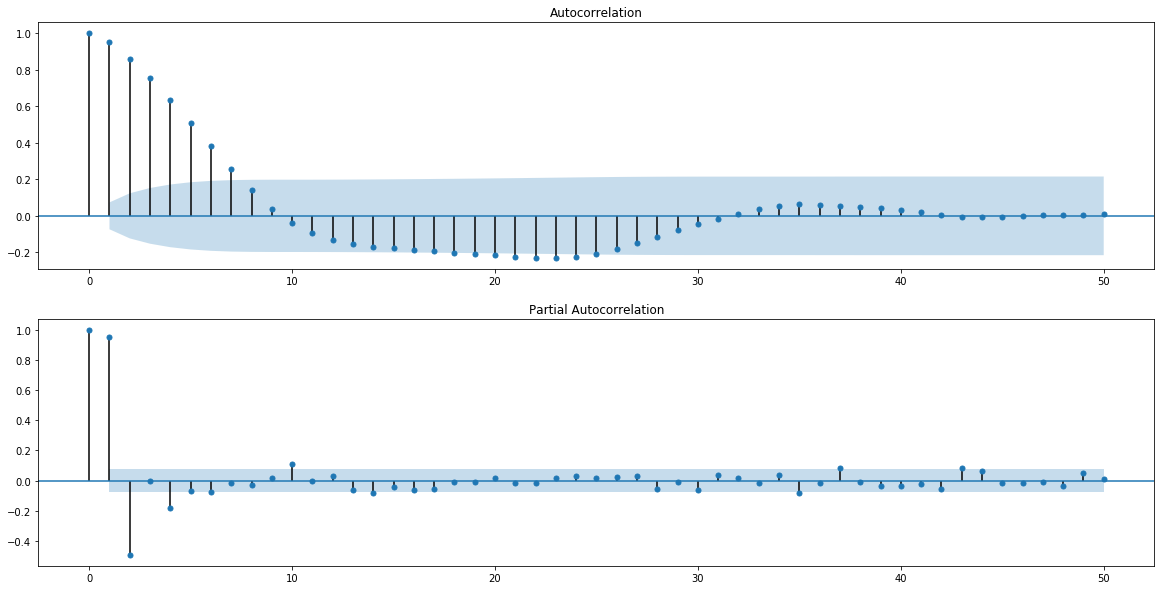

In [44]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ensorange.ANOM, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ensorange.ANOM, lags=50, ax=ax[1])
plt.show()

#### Sunspot observations

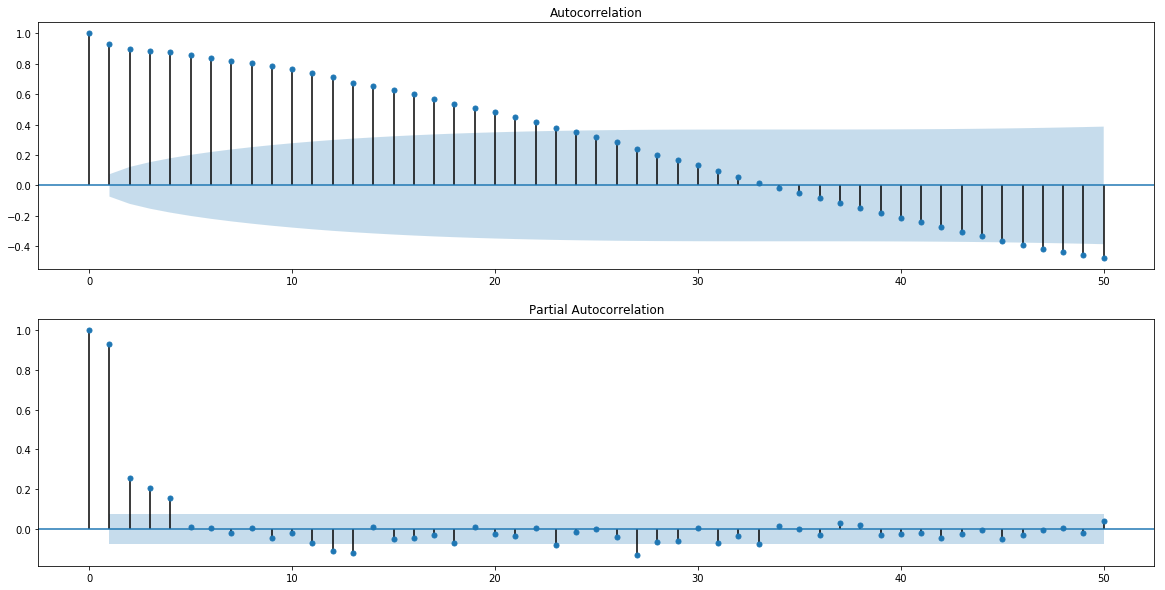

In [45]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(spotsrange.SNvalue, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(spotsrange.SNvalue, lags=50, ax=ax[1])
plt.show()

### Train/Test-split

In [31]:
tr_start,tr_end = '1960-01-01','2010-12-01'
te_start,te_end = '2011-01-01','2018-12-01'

train_anomaly, test_anomaly = anomalyrange[tr_start : tr_end], anomalyrange[te_start:te_end]
train_co2, test_co2 = co2range[tr_start : tr_end], co2range[te_start: te_end]
train_exogenous, test_exogenous = exogenous[tr_start : tr_end], exogenous[te_start: te_end]


### Selecting initial ARMA(p,q)-parameters

Best parameter p=3, q=1

In [30]:
resDiff = sm.tsa.arma_order_select_ic(train_anomaly.anomaly, max_ar=12, max_ma=12)

NameError: name 'train_anomaly' is not defined

In [29]:
#print ('AIC-order: {}' .format(resDiff.aic_min_order))
print ('BIC-order: {}' .format(resDiff.bic_min_order))
#print ('HQIC-order: {}' .format(resDiff.hqic_min_order))

NameError: name 'resDiff' is not defined

## SARIMA model

In [ ]:
#SARIMA model:(p,d,q)(P,D,Q,m)


#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

C:\Users\Simo\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA model MSE:0.06644029306089912


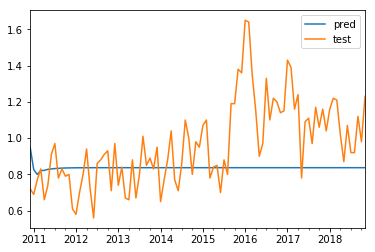

In [66]:
sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(3,1,1),freq='M',seasonal_order=(3,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()

#sarima.summary()
pred = arima.predict(tr_end,te_end) #[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

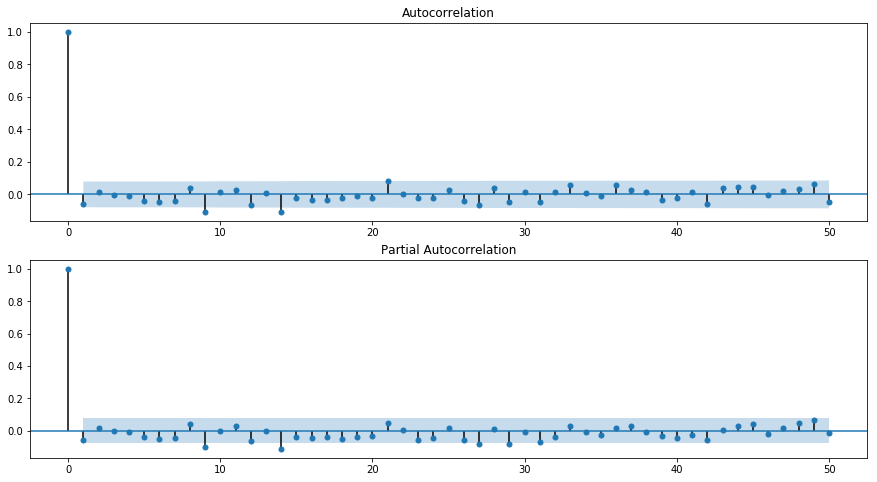

In [65]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [32]:
pred = arima.predict(tr_end,te_end) #[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

ARIMA model MSE:0.10398727384504423


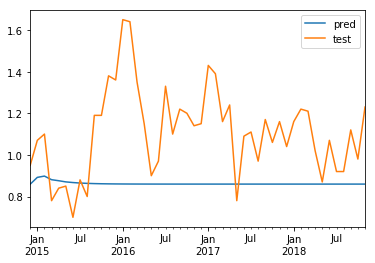

In [33]:
pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

## SARIMAX-model

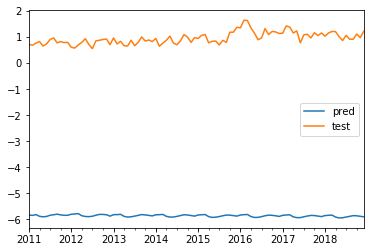

In [92]:
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(3,1,1),seasonal_order=(3,1,1,12),exog = train_co2,
                                enforce_stationarity =False, enforce_invertibility=False).fit()
#sarimax.summary()


pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred[1:]}).plot();plt.show()



In [93]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            anomaly   No. Observations:                  612
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 294.689
Date:                            Fri, 15 Feb 2019   AIC                           -581.377
Time:                                    18:28:41   BIC                           -563.710
Sample:                                01-01-1960   HQIC                          -574.506
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO2filled     -0.0010      0.020     -0.051      0.959      -0.040       0.038
ma.L1         -0.5934      0.034    -17.266      0.000      -0.661      -0.526
ma.S.L12      -0.9726      0.034    -28.656      0.000      -1.039      -0.906
sigma2         0.0204      0.001     17.129      0.000       0.018       0.023
===================================================================================
Ljung-Box (Q):                       51.85   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.10   Prob(JB):                         0.40
Heteroskedasticity (H):               1.05   Skew:                             0.10
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

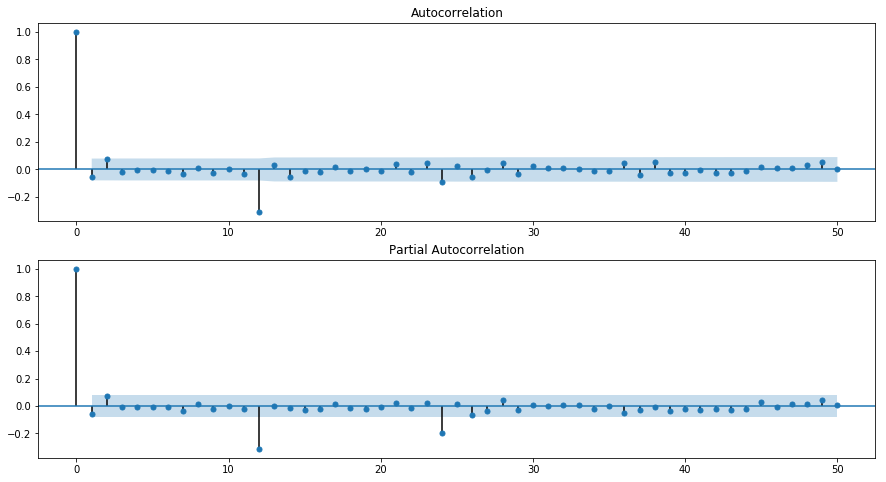

In [82]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error
pred = sarimax.predict(tr_end,te_end,exog = test_co2)
print('ARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred[1:])))



ARIMA model MSE:46.66605076720566


In [72]:
len(test_co2)

96

In [ ]:
sarimax.plot_diagnostics(figsize=(15, 12))

In [124]:
import itertools
import warnings

In [140]:
y = train_anomaly

In [158]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            exog=train_co2)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:148.06738214543893
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:168.1641325230354
ARIMA(0, 0, 0)x(0, 0, 3, 12)12 - AIC:-19.66804279665474
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-368.4937873597595
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-358.0724498788328
ARIMA(0, 0, 0)x(0, 1, 3, 12)12 - AIC:-354.67965797048805
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:20.215667146208972
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:-258.8630096523116
ARIMA(0, 0, 0)x(0, 2, 3, 12)12 - AIC:-252.10863551307472
ARIMA(0, 0, 0)x(0, 3, 1, 12)12 - AIC:512.4609689511133
ARIMA(0, 0, 0)x(0, 3, 2, 12)12 - AIC:115.17200818699106
ARIMA(0, 0, 0)x(0, 3, 3, 12)12 - AIC:107.30342991937903
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-93.59014134738229
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-370.74844145405916
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-353.6283997226131
ARIMA(0, 0, 0)x(1, 0, 3, 12)12 - AIC:-332.11266419694266
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-198.24948886566162
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-366.523

ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:-553.0912418455825
ARIMA(0, 0, 2)x(1, 1, 3, 12)12 - AIC:-539.72738233272
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:62.661410290416065
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:-344.34192513698207
ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:-445.8019340551048
ARIMA(0, 0, 2)x(1, 2, 3, 12)12 - AIC:-441.9413446957068
ARIMA(0, 0, 2)x(1, 3, 0, 12)12 - AIC:218.50382322644862
ARIMA(0, 0, 2)x(1, 3, 1, 12)12 - AIC:-53.73569071273127
ARIMA(0, 0, 2)x(1, 3, 2, 12)12 - AIC:-52.5061775876797
ARIMA(0, 0, 2)x(1, 3, 3, 12)12 - AIC:-114.66611639531098
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:-443.62166861608205
ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:-519.5197398817448
ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:-563.7931197257092
ARIMA(0, 0, 2)x(2, 0, 3, 12)12 - AIC:-547.2709041948867
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:-441.3763231085335
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:-553.2022793998358
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:-555.1408100267647
ARIMA(0, 0, 2)x(2, 1, 3, 12)12 - AIC:-537.502939

In [32]:
#sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(0,1,1),seasonal_order=(0,0,1,12),exog=train_co2,
#                                enforce_stationarity =False, enforce_invertibility=False).fit()

#ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:-572.0785421029348
#ARIMA(0, 0, 3)x(0, 1, 1, 12)12 - AIC:-578.156343087596
#ARIMA(0, 0, 3)x(1, 0, 1, 12)12 - AIC:-582.7157141925927

sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(3,1,1),seasonal_order=(1,1,1,12),exog=train_exogenous,
                                enforce_stationarity =False, enforce_invertibility=False).fit()

C:\Users\Simo\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [42]:
pred = sarima.predict(tr_end,te_end,exog=test_exogenous)
len(pred)
print('ARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred[1:])))

ARIMA model MSE:0.036429730958669145


In [34]:
len(pred)

97

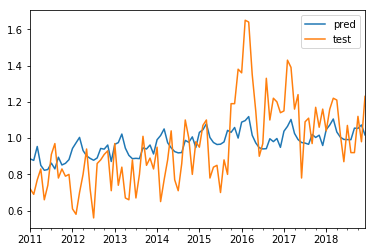

In [43]:
pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred[1:]}).plot();plt.show()